# **Forecasting: Store-Sales**

This project aims to forecast the sales of a company's stores in Ecuador. We work with Time Series to predictions the sales, used tools of the **Pandas**. The Model learning  is the kind Hydrid,  it be first model `RandomForestRegressor` while the second model is `LinearRegression`. 



# **Setting** #

Setup of the system  and necessary libraries.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

 # Allows the use of display() for DataFrames
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"


# Setup notebook
from pathlib import Path
from IPython.display import display

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.signal import periodogram
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor # make for microsoft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import  mean_squared_log_error as msle




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# **Get Data** #

The data is in  [Kaggle Store sales](https://www.kaggle.com/c/store-sales-time-series-forecasting). 


In [2]:
# Paths
comp_dir = Path('../input/store-sales-time-series-forecasting')

# timeInitial
timeInitial = '2017-04'

# Get datas
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col='date'
)

hol = holidays_events.to_period('D')
hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date 

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family','onpromotion', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

oil = pd.read_csv(
    comp_dir / 'oil.csv',
    usecols = ['date', 'dcoilwtico'],
    dtype={'dcoilwtico': 'float32'    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

 
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[timeInitial :'2017-08-15', ]
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # assign new columns
)

df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# Rearray to period

transactions =  pd.read_csv( comp_dir / 'transactions.csv',
                            parse_dates = ['date'], 
                            infer_datetime_format = True, 
                            )

oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()
oil=oil.squeeze()

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()




#  **Exploratory Data Analysis** #

Information preliminar about  `store_sales`.

In [3]:
display(store_sales.info())
display( store_sales.describe().T)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, ('1', 'AUTOMOTIVE', Period('2013-01-01', 'D')) to ('9', 'SEAFOOD', Period('2017-08-15', 'D'))
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sales        float32
 1   onpromotion  uint32 
dtypes: float32(1), uint32(1)
memory usage: 34.4 MB


None

,count,mean,std,min,25%,50%,75%,max
sales,3000888.0,356.758392,1093.275879,0.0,0.0,11.0,195.847252,124717.0
onpromotion,3000888.0,2.602770,12.218882,0.0,0.0,0.0,0.000000,741.0


In [4]:
store_sales['sales'].head()

def salesDecompose(df, share_type='sales', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()
    

### Sales Decompose
In this section shown to sales decompose in three parts;  Observed, Trend and Seasonality, in a range time of  one year. 

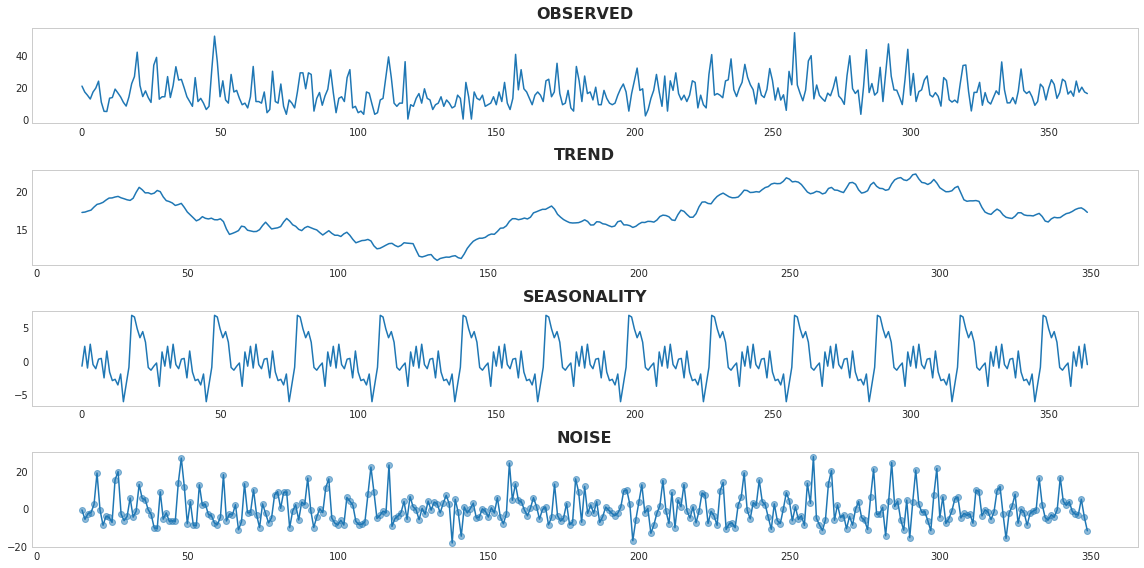

In [5]:
salesDecompose(store_sales, samples= 365, period = 30 )

Here, we maked average sales from time initial `2015`. Then we show Partial Correlation of Lags,  noting the most  significant ones.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 137 entries, 2017-04-01 to 2017-08-15
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        137 non-null    float32
 1   onpromotion  137 non-null    float64
dtypes: float32(1), float64(1)
memory usage: 2.7 KB


None

,sales,onpromotion
date,,
2017-04-01,821.034790,4.180696
2017-04-02,638.973083,4.459035
2017-04-03,468.682159,3.672840
2017-04-04,468.912811,5.227834
2017-04-05,475.101746,8.470258


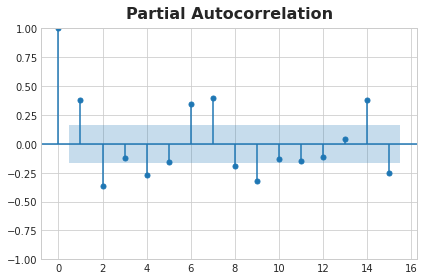

In [6]:
# transactions per store
transactions.info()


# average sales 
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc[timeInitial:]
)


plot_pacf(average_sales.sales, lags=15)


display(average_sales.info())
#ax = average_sales.plot(**plot_params, alpha = 0.5,  title='Averange Sales', ylabel='Items Sold')
#ax.legend();

average_sales.head()

In [7]:
# partial autocorrelation Oil
dfOil = pd.DataFrame(oil)
dfOil.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float32
dtypes: float32(1)
memory usage: 14.3 KB


The price's Oil during three years.

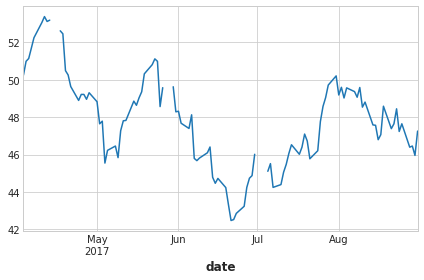

In [8]:
oil[timeInitial:].plot()
plt.show()




In [9]:
dfOil = pd.DataFrame(oil)
dfOil.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float32
dtypes: float32(1)
memory usage: 46.6 KB


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1217 non-null   float32
 1   ma_oil      1211 non-null   float64
dtypes: float32(1), float64(1)
memory usage: 56.1 KB


<AxesSubplot:xlabel='date'>

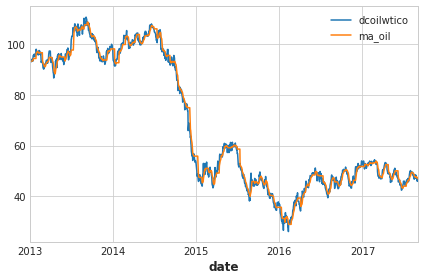

In [10]:
dfOil['ma_oil'] = dfOil['dcoilwtico'].rolling(7).mean() # calculating mean by oil ( there are NaNs  values)
dfOil.fillna(method='ffill', inplace=True)
dfOil.info()

dfOil.plot()
#dfOil.ma_oil[timeInitial:].plot()

# **Model with Oil** #


We started create training  data, used `CalendarFourier`. For determine seasonal we take care `DeterministicProcess`. Futher, we add the Holiday days. 

In [11]:
sdate = '2017-04-01'
edate = '2017-08-15'
y = store_sales.unstack(['store_nbr', 'family']).loc[timeInitial:] 


# y = y.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

In [12]:
X = dp.in_sample()
X1 = X.copy() 
#holidays = holidays.groupby(holidays.index).first() # Removing duplicated holiday at the same date

## Feature Engineering for Holidays

In [13]:
#calendar = X.join(hol)
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')

calendar['NewYear'] = (calendar.index.dayofyear == 1)

calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False # not work day

calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not Weekday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar



calendar.head()

,NewYear,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-01,True,0,1,0,0,0,0,0,0,0,0,1,0,0
2013-01-02,False,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-03,False,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-04,False,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-05,False,1,0,0,0,0,1,0,0,0,0,0,0,1


In [14]:
school_season = [] # Feature for school fluctuations
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar

,NewYear,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-01,True,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-02,False,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,False,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,False,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,False,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,False,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,False,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [15]:
#X_holidays = pd.get_dummies(holidays) # add columns on Holidays, more featured, way matricial

#X2 = X1.join(X_holidays, on='date').fillna(0.0)


In [16]:
#X = X.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

oilInitial = oil[timeInitial:] 

fourier = CalendarFourier(freq='M', order=4)
dpOil = DeterministicProcess(
    index=oilInitial.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

Xoil = dpOil.in_sample()

Xoil.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-04-03,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406737,0.913545,0.743145,0.669131,9.510565e-01,0.309017,0.994522,-0.104528
2017-04-04,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.587785,0.809017,0.951057,0.309017,9.510565e-01,-0.309017,0.587785,-0.809017
2017-04-05,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.743145,0.669131,0.994522,-0.104528,5.877853e-01,-0.809017,-0.207912,-0.978148
2017-04-06,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.866025,0.500000,0.866025,-0.500000,1.224647e-16,-1.000000,-0.866025,-0.500000
2017-04-07,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.951057,0.309017,0.587785,-0.809017,-5.877853e-01,-0.809017,-0.951057,0.309017


In [17]:

missingValueCount = X1.isnull().sum()
print('Num_null: ' , missingValueCount.sum() )
#X2 = X2.dropna()
#X2 = X2.fillna(0)

Num_null:  0


Add new columns to train set. From Lag's graph, we consider seven Lags.

In [18]:
calendar['Oil'] = dfOil['ma_oil']

#X2.Oil.fillna(value = oil.mean() , inplace=True ) # drop values NaNs
#X2.fillna(method='ffill') # drop values NaNs

#X2['salesLag1'] = average_sales.sales.shift(periods=1, freq='D')
#X2['salesLag2'] = average_sales.sales.shift(2)


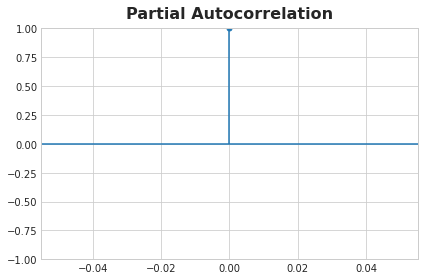

In [19]:
_ = plot_pacf(calendar.Oil, lags = 12) # Lagplot oil price (Feature Engineering)

# first 
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags{l}'] = calendar.Oil.shift(l)


In [20]:
X1 = X1.join(calendar)

X1['Onpromotion'] = average_sales['onpromotion']
X1['salesLag7'] = average_sales.sales.shift(7)
#X2.fillna(method='ffill') # drop values NaNs
X1.dropna(how='any', axis=0, inplace=True) # drop values NaNs
dateRange =  X1.index


# train set and target train
y_train = y.loc[dateRange]
Xtrain=X1.copy()
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 36 entries, 2017-04-13 to 2017-08-11
Freq: D
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            36 non-null     float64
 1   trend            36 non-null     float64
 2   s(2,7)           36 non-null     float64
 3   s(3,7)           36 non-null     float64
 4   s(4,7)           36 non-null     float64
 5   s(5,7)           36 non-null     float64
 6   s(6,7)           36 non-null     float64
 7   s(7,7)           36 non-null     float64
 8   sin(1,freq=M)    36 non-null     float64
 9   cos(1,freq=M)    36 non-null     float64
 10  sin(2,freq=M)    36 non-null     float64
 11  cos(2,freq=M)    36 non-null     float64
 12  sin(3,freq=M)    36 non-null     float64
 13  cos(3,freq=M)    36 non-null     float64
 14  sin(4,freq=M)    36 non-null     float64
 15  cos(4,freq=M)    36 non-null     float64
 16  NewYear          36 non-null     bool 

In [21]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 36 entries, 2017-04-13 to 2017-08-11
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 501.5 KB


#  **Hybrid Model**

First  model to get us seasonal information. Meanwhile, the second model will take care of training the rest of the data.
While, second model to  training  rest of train set.

In [22]:
# The data set is already  divided, test Train
model1 = RandomForestRegressor(random_state = 42)
model1.fit(Xtrain, y_train)

y_fit = model1.predict(Xtrain)

y_resid = y_train - y_fit



#model = LinearRegression(fit_intercept=False)
model = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True) # argument to improvemnt considerment performance

# model = LGBMRegressor(random_state = 42) "not work with  mulpli-columns"

model.fit(Xtrain, y_resid)
y_pred = pd.DataFrame(model.predict(Xtrain), index=Xtrain.index, columns=y_train.columns)


yLR_RF = y_pred + y_fit
#y_pred_boosted = xgb.predict(X_test) + y_pred

In the next figure, we see the `Produce` sales at Store 1, compare the value of sales and value prediction by the hybrid model.

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 36 entries, 2017-04-13 to 2017-08-11
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 501.5 KB


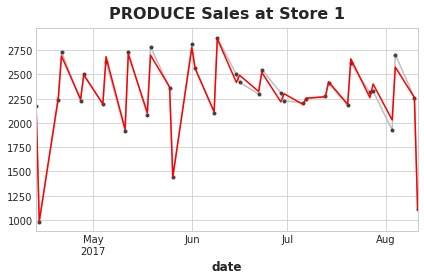

In [23]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y_train.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params) # choose single store 1 and family equal produce. 
ax = yLR_RF.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='red')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

y_train.info()

### Metrics

It's calculating metrics:

- Mean Absolute Error MAE
- Root Mean Squared Log Error RMSE

In [24]:
Y = y_train.loc(axis=1)['sales', STORE_NBR, FAMILY]
Ypred = yLR_RF.loc(axis=1)['sales', STORE_NBR, FAMILY]

yfit_lnr = pd.DataFrame(yLR_RF, index = Xtrain.index, columns = y_train.columns).clip(0.)

Mae = np.round(mae(Y, Ypred), 3)  
Rmsle =  np.round(msle(Y, Ypred)**0.5, 3 )

In [25]:
y_pred2   = yLR_RF.stack(['store_nbr', 'family']).reset_index()
y_target = y_train.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred2['sales'].clip(0.) # Sales should be >= 0

print('MAE:', Mae, '\n', 
      'RMSLE', Rmsle)

print( y_target.groupby('family').apply(lambda r: np.sqrt(msle(r['sales'], r['sales_pred'] ))) )
print('LNR RMSLE :', np.sqrt(  msle(y_train, yfit_lnr) ))

MAE: 35.07 
 RMSLE 0.02
family
AUTOMOTIVE                    0.168620
BABY CARE                     0.068226
BEAUTY                        0.168116
BEVERAGES                     0.164467
BOOKS                         0.045115
BREAD/BAKERY                  0.124112
CELEBRATION                   0.205321
CLEANING                      0.195187
DAIRY                         0.129578
DELI                          0.108314
EGGS                          0.133592
FROZEN FOODS                  0.130673
GROCERY I                     0.171422
GROCERY II                    0.221027
HARDWARE                      0.167944
HOME AND KITCHEN I            0.189891
HOME AND KITCHEN II           0.218001
HOME APPLIANCES               0.108219
HOME CARE                     0.110368
LADIESWEAR                    0.172500
LAWN AND GARDEN               0.189906
LINGERIE                      0.218197
LIQUOR,WINE,BEER              0.263363
MAGAZINES                     0.159854
MEATS                         0.1

We seek, there is overfiting. 

# Test set

The test set, building with same variables the train set, it has 16 steps.

### Missing Values ###

In [26]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()


average_sales_test = (
    df_test
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)


#df_test = df_test.loc['2017'] 
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'





X_test2 = X_test.join(calendar)

#X_test = X_test.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')
#X_test1 = X_test.join( Xoil , on='date', rsuffix='RT').fillna(method = 'bfill')

X_test1 =  X_test.copy()
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          16 non-null     float64
 1   trend          16 non-null     float64
 2   s(2,7)         16 non-null     float64
 3   s(3,7)         16 non-null     float64
 4   s(4,7)         16 non-null     float64
 5   s(5,7)         16 non-null     float64
 6   s(6,7)         16 non-null     float64
 7   s(7,7)         16 non-null     float64
 8   sin(1,freq=M)  16 non-null     float64
 9   cos(1,freq=M)  16 non-null     float64
 10  sin(2,freq=M)  16 non-null     float64
 11  cos(2,freq=M)  16 non-null     float64
 12  sin(3,freq=M)  16 non-null     float64
 13  cos(3,freq=M)  16 non-null     float64
 14  sin(4,freq=M)  16 non-null     float64
 15  cos(4,freq=M)  16 non-null     float64
dtypes: float64(16)
memory usage: 2.7 KB


Preparation Test set.

In [27]:



X_test2['Onpromotion'] = average_sales_test['onpromotion']
#X_test2['Oil'] = oil




#X_test2.fillna(method='ffill', inplace=True)


#X_test2['OilLagsOne'] = oil.shift(periods=1, freq='D')
#X_test2['salesLag1'] = average_sales.sales.shift(periods=16, freq='D')
#X_test2['salesLag2'] = average_sales.sales.shift(periods=16, freq='D')
X_test2['salesLag7'] = average_sales.sales.shift(periods=16, freq='D')




In [28]:
X_test2.fillna(method='ffill', inplace=True)
X_test2.fillna(method='bfill', inplace=True)

X_test2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,type_Holiday,type_Transfer,type_Work Day,school_season,Oil,oil_lags1,oil_lags2,oil_lags3,Onpromotion,salesLag7
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,138.0,0.0,0.0,0.0,1.0,0.0,0.0,0.101168,-0.994869,...,0,0,0,1,48.281429,48.648572,48.934286,48.934286,17.137486,497.113831
2017-08-17,1.0,139.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.101168,-0.994869,...,0,0,0,1,47.995714,48.281429,48.648572,48.934286,4.211560,554.729370
2017-08-18,1.0,140.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.299363,-0.954139,...,0,0,0,1,47.852857,47.995714,48.281429,48.648572,7.731201,541.364746
2017-08-19,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,...,0,0,0,1,47.852857,47.852857,47.995714,48.281429,4.833895,408.568176
2017-08-20,1.0,142.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0,0,0,1,47.852857,47.852857,47.852857,47.995714,5.338384,464.520599


In [29]:
y_pred1 = model1.predict(X_test2)
y_pred2 = model.predict(X_test2)

print(y_pred1.shape, '\n ',  y_pred2.shape)

(16, 3564) 
  (16, 3564)


In [30]:
y_final = y_pred2 + y_pred1


## Creation Submit



In [31]:
y_submit = pd.DataFrame(y_final, index=X_test2.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [32]:

from datetime import datetime

now = datetime.now()
print('\n', now)



 2022-05-16 22:45:00.717072


File submit.

In [33]:
Xtrain.columns == X_test2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [34]:
y_submit.head()


id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     2.528893
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     9.751864
                     BEVERAGES   3000891  2504.618612
                     BOOKS       3000892    -2.234031

## Pre-Processing ##

### Selection only Giants or Dwarfs ###

## Balance ##

In [35]:
# dividir set 



# from sklearn.utils import resample
# dfGiantsDownSample = resample(dfGiants, 
  #                           replace = False, # sample without replacement
   #                          n_samples = num_of_dwarf,
   #                          random_state =1 
 #                            )
#dfDownSampled = pd.concat([dfGiantsDownSample , dfDwarfs] )

#dfBalanced= dfDownSampled.reset_index(drop=True)

# dataStar = dfBalanced.sample(frac=1).reset_index(drop=True) # shuffle
# dfCopyStar = dataStar.copy()

## Visualization ##

## Correlation Linear ##

## Data Cleaning ##

# **Data Processing** #

### Train and test Set ###

In [36]:
## Stratified ##
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(data, data["variableStratificada"]):
#strat_train_set = housing.loc[train_index]
#strat_test_set = housing.loc[test_index]

#from  sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')

#from  sklearn.preprocessing import OneHotEncoder
#catEncoder = OneHotEncoder()

## numerical ##
#from  sklearn.pipeline import Pipeline
#from  sklearn.preprocessing import StandardScaler
#numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),])
# new_variable_transformed_numerical = num_pipeline.fit_transform(varible_numerica)

## numerical and categorial ##
#from sklearn import ColumnTransformer
#numerical_attribs = list(numerical_columns)
#categorical_attribs = list(categorial_columns)
#full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_attribs),("cat", OneHotEncoder(), categorical_attribs),])
#dataTotal_prepared = full_pipeline.fit_transform(dataTotal) 

## Target ## 

## Featuring Engineering ##

##  Pipeline and Featuring Scaling ##

 # **MODEL** # 

#### Models ####

In [37]:
### stratified CV ### see pag 136  Geron's book
#from sklearn.model_selection import StratifiedKFold
#from sklearn.base import clone
#skfolds = StratifiedKFold(n_splits=3, random_state=42)

# **Refinament** #

# **Deploy** #